In [ ]:
## 1. Setup and Configuration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')
sns.set_palette("viridis")
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', 1000)

import sys
sys.path.append('../src')


In [6]:
!pip install azure-storage-blob


In [7]:
from utils import PipelineUtils
from data_processing import DataProcessor
# Initialize utilities
utils = PipelineUtils()
processor = DataProcessor()
config = utils.load_config('../config/config.json')
print("Configuration loaded:", config.keys())

2025-09-21 01:19:24,437 - utils - INFO - Configuration loaded from ..\config\config.json


Configuration loaded: dict_keys(['azure_ml', 'azure_storage', 'data_processing', 'clustering', 'model_training', 'deployment', 'hyperparameters', 'monitoring', 'api', 'features', 'paths', 'environment'])


In [8]:
#  Load Data
# ===============================
try:
    df = processor.load_data_from_azure_blob()
except:
    df = processor.load_data_from_local('../data/marketing_campaign.csv')

print(f"Data shape: {df.shape}")
print(f"Columns: {list(df.columns)}")

2025-09-21 01:20:44,554 - data_processing - INFO - Loading data from Azure Blob Storage...
2025-09-21 01:20:44,556 - data_processing - ERROR - Error loading data from Azure Blob: 'NoneType' object has no attribute 'rstrip'
2025-09-21 01:20:44,557 - data_processing - INFO - Loading data from local file: ../data/marketing_campaign.csv
2025-09-21 01:20:44,623 - data_processing - INFO - Data loaded successfully. Shape: (2240, 29)


Data shape: (2240, 29)
Columns: ['ID', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response']


In [9]:
#  Initial Exploration
# ===============================
print("=== DATA INFO ===")
df.info()
print("\n=== FIRST 5 ROWS ===")
display(df.head())

print("\n=== MISSING VALUES ===")
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_values,'Percentage': missing_percentage})
display(missing_df[missing_df['Missing Values'] > 0])

=== DATA INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases   

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,3,11,0



=== MISSING VALUES ===


,Missing Values,Percentage
Income,24,1.071429


In [10]:
#  Basic Statistics
# ===============================
numerical_cols = df.select_dtypes(include=[np.number]).columns
categorical_cols = df.select_dtypes(include=['object']).columns

print("=== NUMERICAL COLUMNS STATISTICS ===")
display(df[numerical_cols].describe())

print("\n=== CATEGORICAL COLUMNS STATISTICS ===")
for col in categorical_cols:
    print(f"\n{col}:")
    print(df[col].value_counts().head())

# ===============================

=== NUMERICAL COLUMNS STATISTICS ===


,ID,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
count,2240.000000,2240.000000,2216.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.000000,2240.0,2240.0,2240.000000
mean,5592.159821,1968.805804,52247.251354,0.444196,0.506250,49.109375,303.935714,26.302232,166.950000,37.525446,27.062946,44.021875,2.325000,4.084821,2.662054,5.790179,5.316518,0.072768,0.074554,0.072768,0.064286,0.013393,0.009375,3.0,11.0,0.149107
std,3246.662198,11.984069,25173.076661,0.538398,0.544538,28.962453,336.597393,39.773434,225.715373,54.628979,41.280498,52.167439,1.932238,2.778714,2.923101,3.250958,2.426645,0.259813,0.262728,0.259813,0.245316,0.114976,0.096391,0.0,0.0,0.356274
min,0.000000,1893.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
25%,2828.250000,1959.000000,35303.000000,0.000000,0.000000,24.000000,23.750000,1.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
50%,5458.500000,1970.000000,51381.500000,0.000000,0.000000,49.000000,173.500000,8.000000,67.000000,12.000000,8.000000,24.000000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
75%,8427.750000,1977.000000,68522.000000,1.000000,1.000000,74.000000,504.250000,33.000000,232.000000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.0,11.0,0.000000
max,11191.000000,1996.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,263.000000,362.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.0,11.0,1.000000



=== CATEGORICAL COLUMNS STATISTICS ===

Education:
Education
Graduation    1127
PhD            486
Master         370
2n Cycle       203
Basic           54
Name: count, dtype: int64

Marital_Status:
Marital_Status
Married     864
Together    580
Single      480
Divorced    232
Widow        77
Name: count, dtype: int64

Dt_Customer:
Dt_Customer
31-08-2012    12
14-02-2013    11
12-09-2012    11
12-05-2014    11
20-08-2013    10
Name: count, dtype: int64


In [11]:
#  Data Cleaning
# ===============================
df_clean = processor.clean_data()
print("=== AFTER CLEANING ===")
print(f"Shape: {df_clean.shape}")
print("Missing values:", df_clean.isnull().sum().sum())

2025-09-21 01:27:42,723 - data_processing - INFO - Starting data cleaning...
2025-09-21 01:27:42,724 - data_processing - INFO - Original data shape: (2240, 29)
2025-09-21 01:27:42,727 - data_processing - INFO - Original missing values:
ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int

=== AFTER CLEANING ===
Shape: (2240, 29)
Missing values: 0


In [12]:
#  Outlier Detection
# ===============================
print("=== OUTLIER DETECTION ===")
for col in numerical_cols:
    if col not in ['ID', 'Z_CostContact', 'Z_Revenue']:
        outliers = utils.detect_outliers(df_clean, col)
        print(f"{col}: {outliers.sum()} outliers detected")

# ===============================

=== OUTLIER DETECTION ===
Year_Birth: 3 outliers detected
Income: 8 outliers detected
Kidhome: 0 outliers detected
Teenhome: 0 outliers detected
Recency: 0 outliers detected
MntWines: 35 outliers detected
MntFruits: 227 outliers detected
MntMeatProducts: 175 outliers detected
MntFishProducts: 223 outliers detected
MntSweetProducts: 248 outliers detected
MntGoldProds: 207 outliers detected
NumDealsPurchases: 86 outliers detected
NumWebPurchases: 4 outliers detected
NumCatalogPurchases: 23 outliers detected
NumStorePurchases: 0 outliers detected
NumWebVisitsMonth: 8 outliers detected
AcceptedCmp3: 163 outliers detected
AcceptedCmp4: 167 outliers detected
AcceptedCmp5: 163 outliers detected
AcceptedCmp1: 144 outliers detected
AcceptedCmp2: 30 outliers detected
Complain: 21 outliers detected
Response: 334 outliers detected


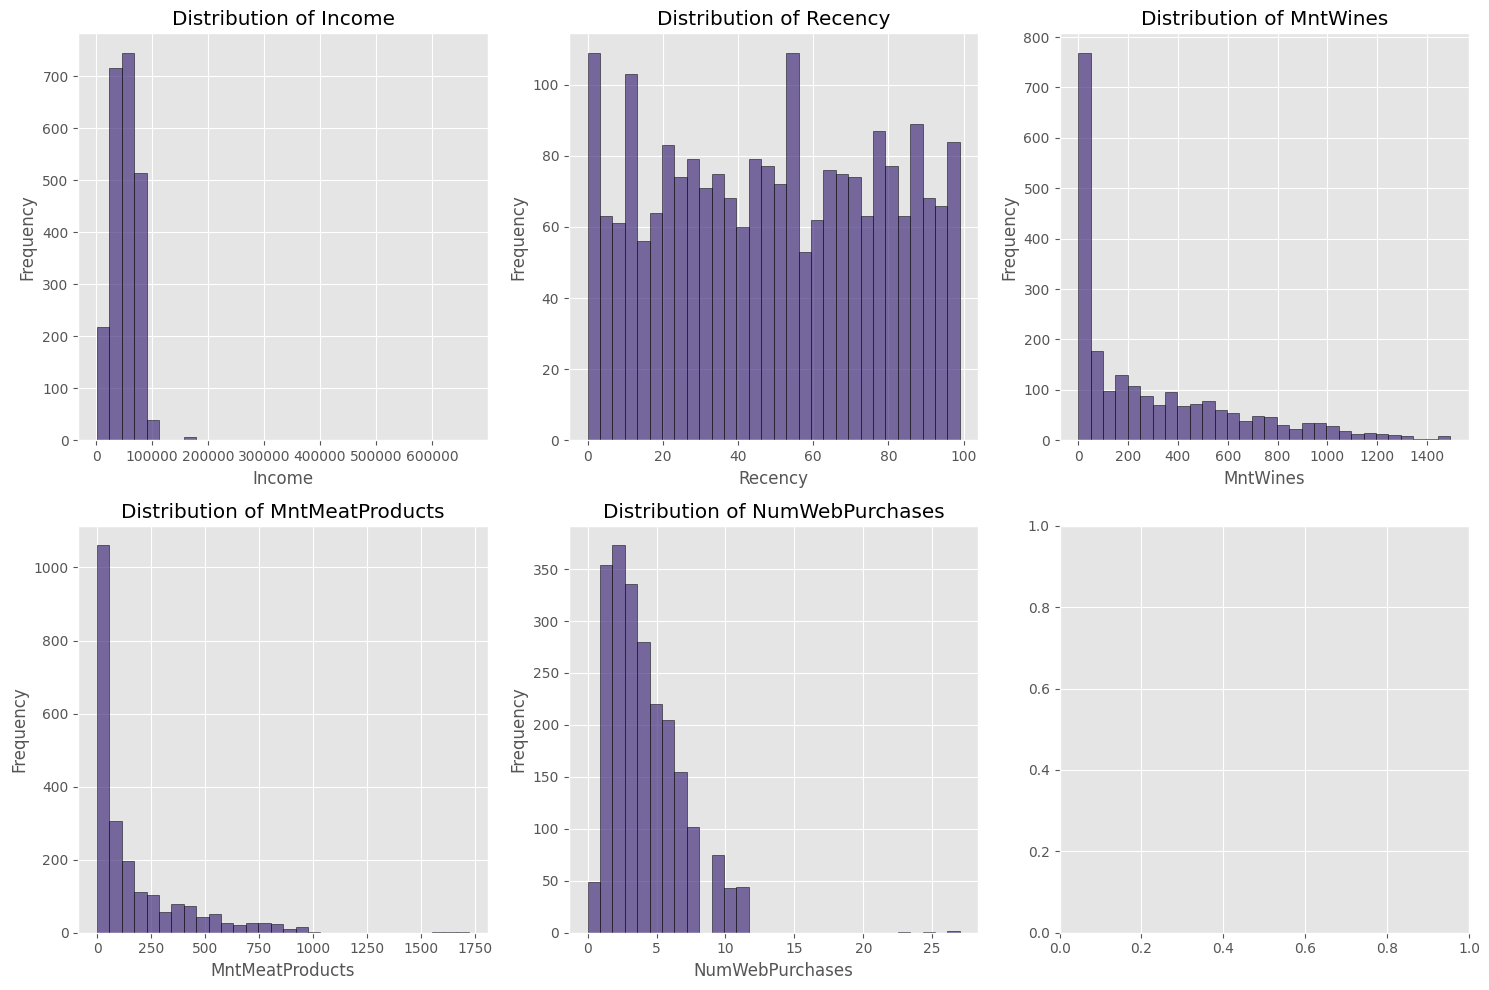

In [13]:
#  Data Visualization
# ===============================
# Numerical distributions
key_numerical = ['Income', 'Recency', 'MntWines', 'MntMeatProducts', 'NumWebPurchases']
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.ravel()
for i, col in enumerate(key_numerical[:6]):
    if col in df_clean.columns:
        axes[i].hist(df_clean[col].dropna(), bins=30, alpha=0.7, edgecolor='black')
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frequency')
plt.tight_layout()
plt.show()

2025-09-21 01:30:10,851 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-09-21 01:30:10,852 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-09-21 01:30:10,858 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-09-21 01:30:10,860 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


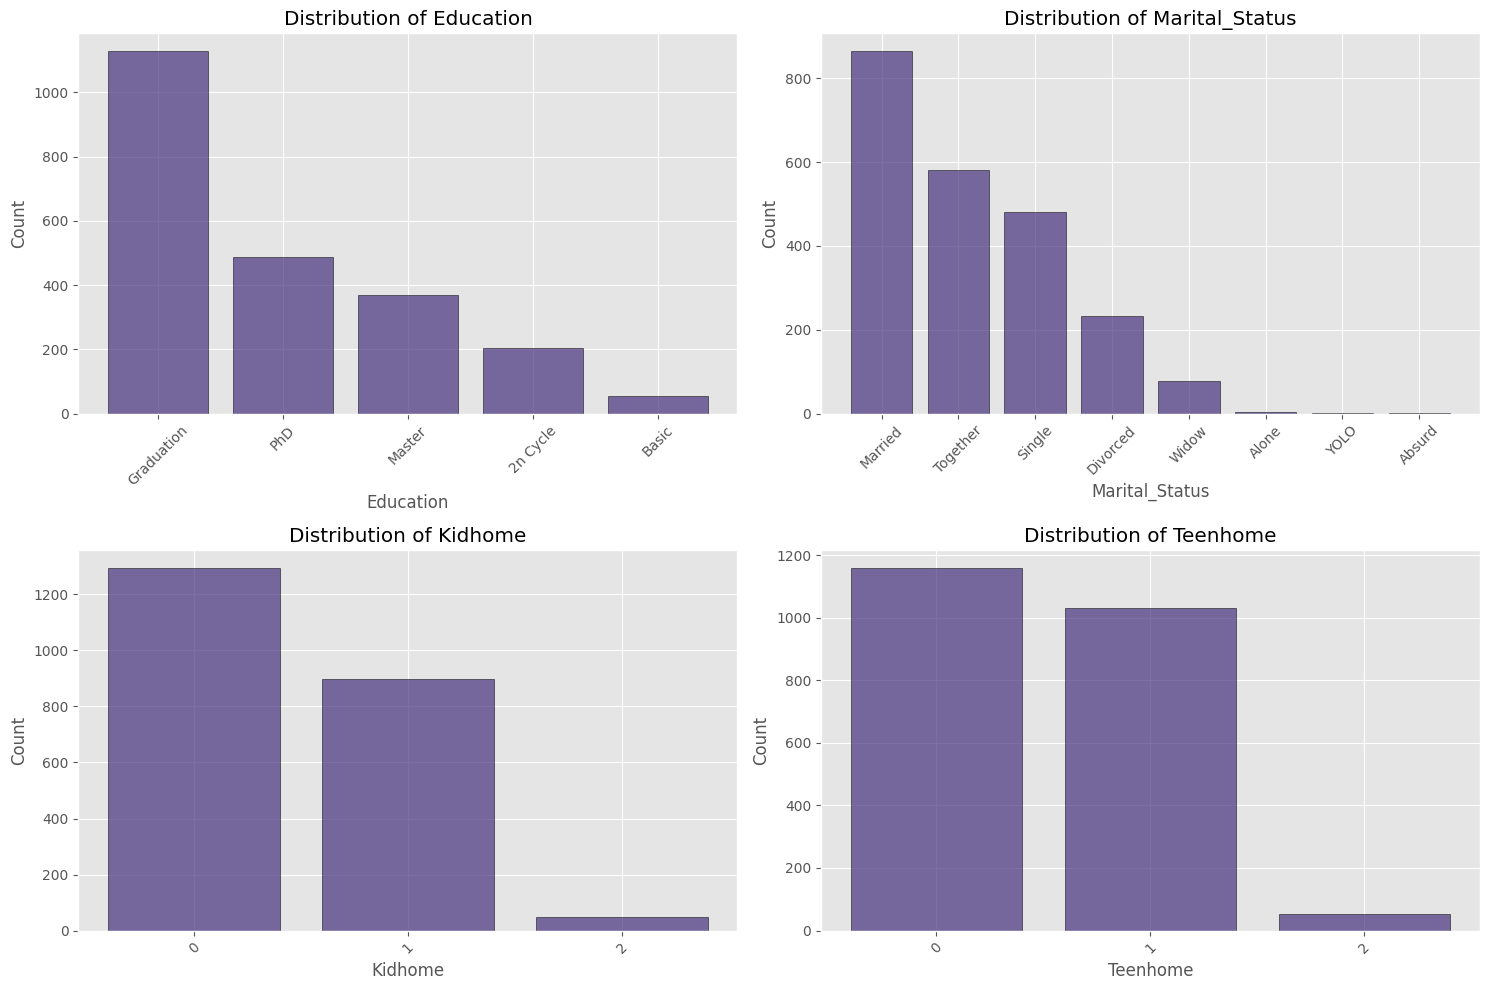

In [14]:
# Categorical distributions
categorical_cols_plot = ['Education', 'Marital_Status', 'Kidhome', 'Teenhome']
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()
for i, col in enumerate(categorical_cols_plot):
    if col in df_clean.columns:
        value_counts = df_clean[col].value_counts()
        axes[i].bar(value_counts.index.astype(str), value_counts.values, alpha=0.7, edgecolor='black')
        axes[i].set_title(f'Distribution of {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Count')
        axes[i].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

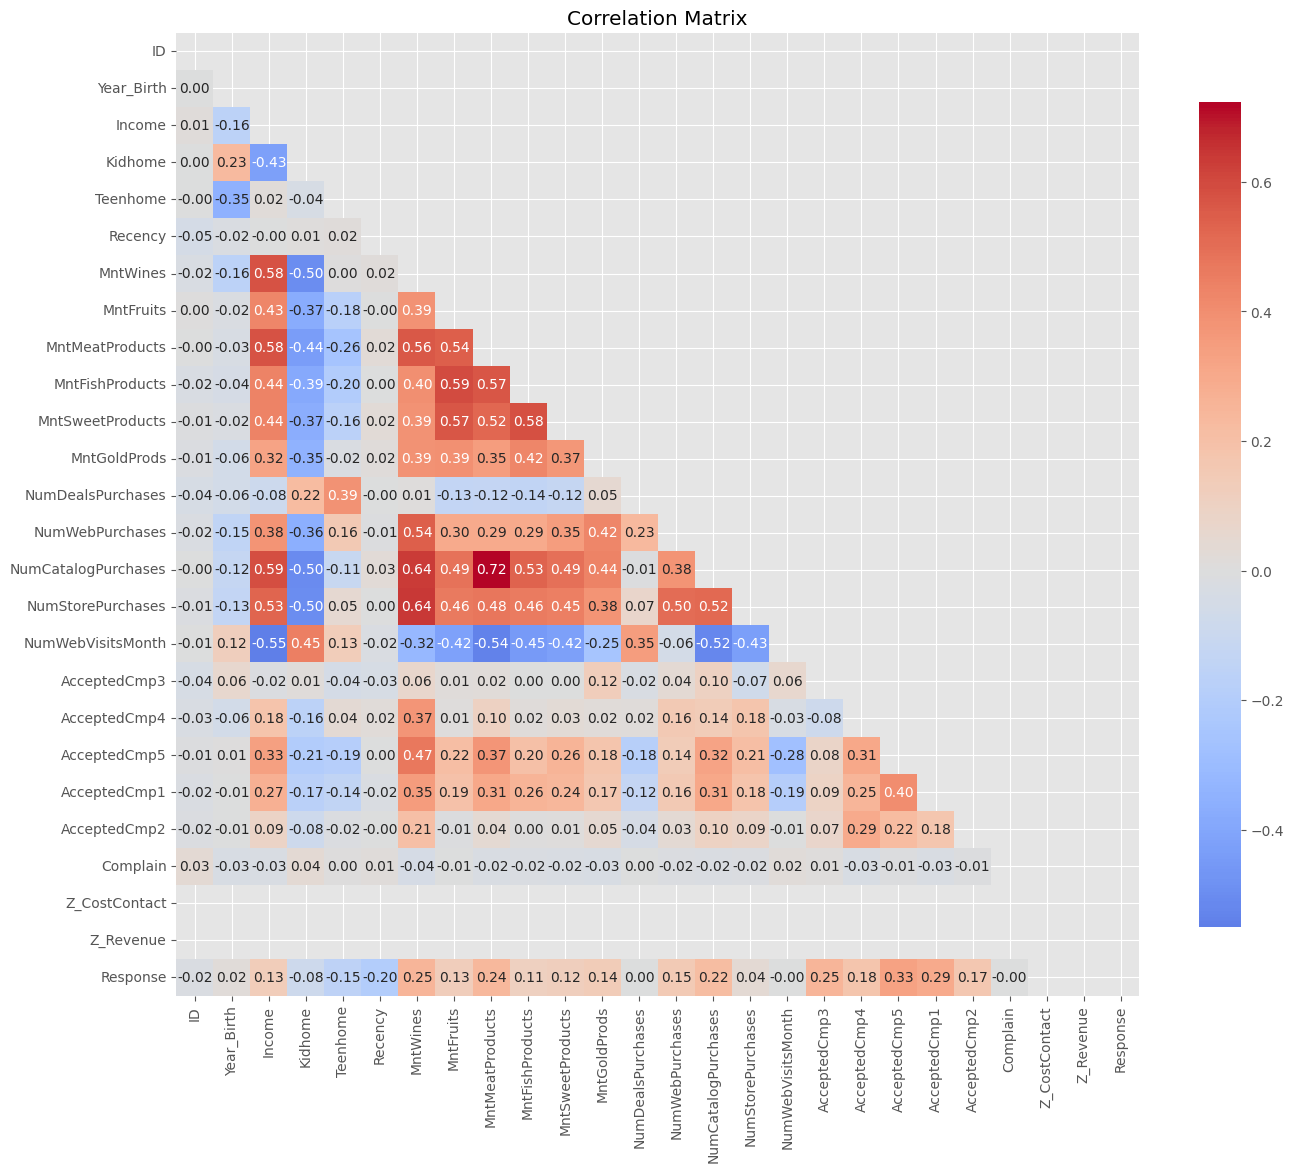

=== STRONG CORRELATIONS (|r| > 0.5) ===


NumCatalogPurchases  MntMeatProducts        0.723827
MntMeatProducts      NumCatalogPurchases    0.723827
MntWines             NumStorePurchases      0.642100
NumStorePurchases    MntWines               0.642100
NumCatalogPurchases  MntWines               0.635226
MntWines             NumCatalogPurchases    0.635226
MntFruits            MntFishProducts        0.594804
MntFishProducts      MntFruits              0.594804
Income               NumCatalogPurchases    0.586826
NumCatalogPurchases  Income                 0.586826
dtype: float64

In [15]:
# Correlation matrix
correlation_matrix = utils.plot_correlation_matrix(df_clean, figsize=(14,12))
print("=== STRONG CORRELATIONS (|r| > 0.5) ===")
high_corr = correlation_matrix.unstack().sort_values(key=abs, ascending=False)
high_corr = high_corr[high_corr != 1.0]
display(high_corr[abs(high_corr) > 0.5].head(10))

In [16]:
#  RFM Analysis
# ===============================
rfm_df = processor.create_rfm_features()
print("RFM DataFrame shape:", rfm_df.shape)
display(rfm_df.head())

rfm_stats = utils.calculate_statistics(rfm_df)
for feature, stats in rfm_stats.items():
    if feature in ['Recency', 'Frequency', 'Monetary']:
        print(f"\n{feature}:")
        for stat, value in stats.items():
            print(f"  {stat}: {value}")

2025-09-21 01:32:41,469 - data_processing - INFO - Creating RFM features...
2025-09-21 01:32:41,484 - data_processing - INFO - Snapshot date for RFM: 2014-06-30 00:00:00
2025-09-21 01:32:41,834 - data_processing - INFO - RFM features created. Shape: (2240, 4)
2025-09-21 01:32:41,859 - data_processing - INFO - RFM stats:
                 ID      Recency  Frequency       Monetary
count   2240.000000  2240.000000     2240.0    2240.000000
mean    5592.159821   354.582143        1.0   52237.975446
std     3246.662198   202.122512        0.0   25037.955891
min        0.000000     1.000000        1.0    1730.000000
25%     2828.250000   181.750000        1.0   35538.750000
50%     5458.500000   356.500000        1.0   51381.500000
75%     8427.750000   530.000000        1.0   68289.750000
max    11191.000000   700.000000        1.0  666666.000000


RFM DataFrame shape: (2240, 4)


,ID,Recency,Frequency,Monetary
0,0,422,1,70951.0
1,1,15,1,57091.0
2,9,681,1,46098.0
3,13,343,1,25358.0
4,17,297,1,60491.0



Recency:
  mean: 354.58214285714286
  median: 356.5
  std: 202.12251234854045
  min: 1.0
  max: 700.0
  q1: 181.75
  q3: 530.0
  skewness: -0.015216085603730034
  kurtosis: -1.1946503810404776
  missing_values: 0
  missing_percentage: 0.0
  zeros: 0
  outliers: 0

Frequency:
  mean: 1.0
  median: 1.0
  std: 0.0
  min: 1.0
  max: 1.0
  q1: 1.0
  q3: 1.0
  skewness: 0.0
  kurtosis: 0.0
  missing_values: 0
  missing_percentage: 0.0
  zeros: 0
  outliers: 0

Monetary:
  mean: 52237.97544642857
  median: 51381.5
  std: 25037.955890621895
  min: 1730.0
  max: 666666.0
  q1: 35538.75
  q3: 68289.75
  skewness: 6.800947406327354
  kurtosis: 161.40014418235637
  missing_values: 0
  missing_percentage: 0.0
  zeros: 0
  outliers: 8


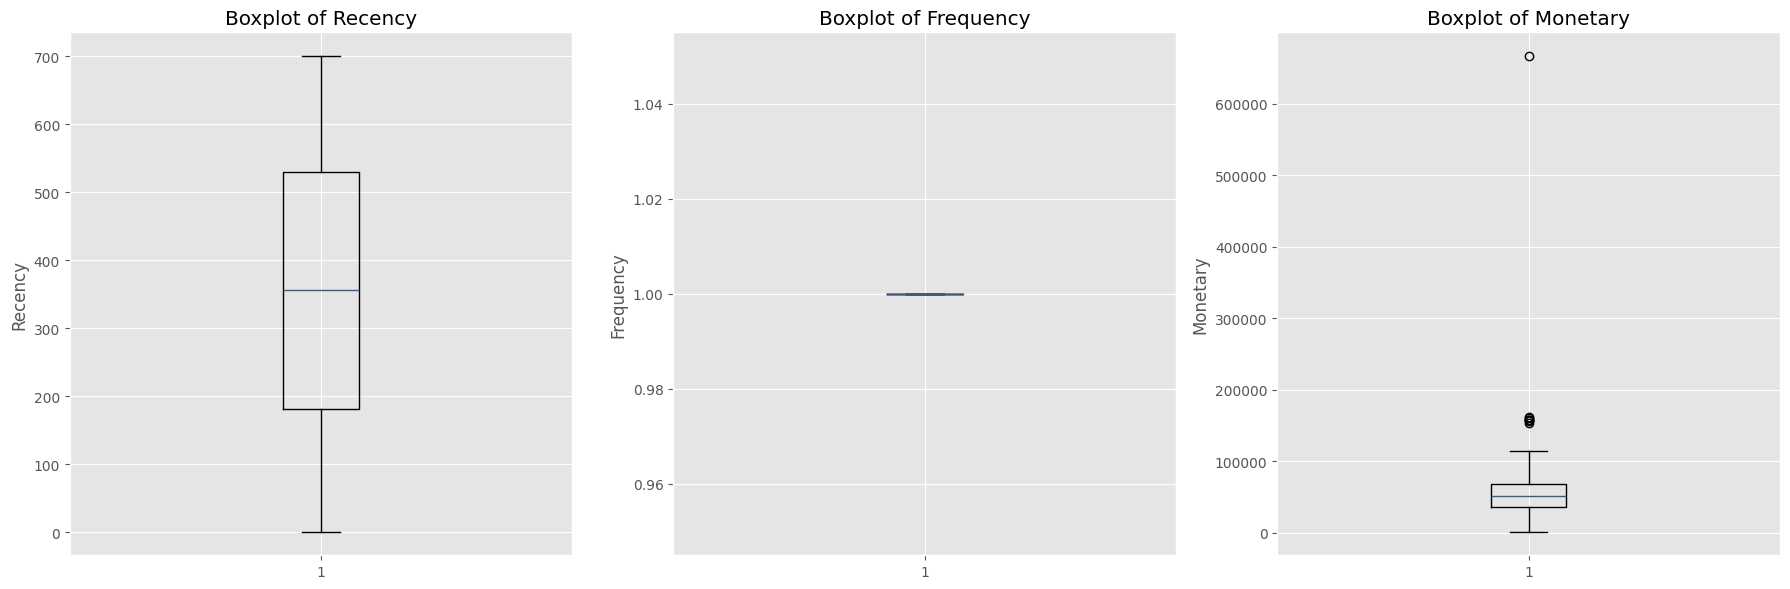

In [17]:
# Boxplots of RFM
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
rfm_features = ['Recency', 'Frequency', 'Monetary']
for i, feature in enumerate(rfm_features):
    axes[i].boxplot(rfm_df[feature].dropna())
    axes[i].set_title(f'Boxplot of {feature}')
    axes[i].set_ylabel(feature)
plt.tight_layout()
plt.show()

In [18]:
#  Churn Analysis
# ===============================
rfm_with_churn = processor.create_churn_label(recency_threshold=90)
print("Churn distribution:")
print(rfm_with_churn['churn'].value_counts())
print(f"Churn rate: {rfm_with_churn['churn'].mean()*100:.2f}%")

# RFM features by churn
churn_stats = rfm_with_churn.groupby('churn').agg({
    'Recency':['mean','std'],
    'Frequency':['mean','std'],
    'Monetary':['mean','std']
}).round(2)
display(churn_stats)

2025-09-21 01:34:22,562 - data_processing - INFO - Creating churn label with threshold: 90 days
2025-09-21 01:34:22,565 - data_processing - INFO - Churn distribution:
churn
1    1960
0     280
Name: count, dtype: int64
2025-09-21 01:34:22,571 - data_processing - INFO - Churn rate: 87.50%


Churn distribution:
churn
1    1960
0     280
Name: count, dtype: int64
Churn rate: 87.50%


Recency         Frequency       Monetary          
         mean     std      mean  std      mean       std
churn                                                   
0       46.86   25.42       1.0  0.0  53138.63  21447.21
1      398.54  176.45       1.0  0.0  52109.31  25511.94

In [19]:
#  Key Findings
# ===============================
print("=== KEY FINDINGS ===")
print(f"1. Dataset contains {df_clean.shape[0]} customers with {df_clean.shape[1]} features")
print(f"2. Churn rate: {rfm_with_churn['churn'].mean()*100:.2f}%")
print(f"3. Key RFM statistics:")
print(f"   - Recency: Mean={rfm_with_churn['Recency'].mean():.2f}, Std={rfm_with_churn['Recency'].std():.2f}")
print(f"   - Frequency: Mean={rfm_with_churn['Frequency'].mean():.2f}, Std={rfm_with_churn['Frequency'].std():.2f}")
print(f"   - Monetary: Mean={rfm_with_churn['Monetary'].mean():.2f}, Std={rfm_with_churn['Monetary'].std():.2f}")
print(f"4. Customers who churn have higher Recency: {churn_stats.loc[1,('Recency','mean')]:.2f} vs {churn_stats.loc[0,('Recency','mean')]:.2f}")
print(f"5. Customers who stay have higher Frequency: {churn_stats.loc[0,('Frequency','mean')]:.2f} vs {churn_stats.loc[1,('Frequency','mean')]:.2f}")

# ===============================

=== KEY FINDINGS ===
1. Dataset contains 2240 customers with 29 features
2. Churn rate: 87.50%
3. Key RFM statistics:
   - Recency: Mean=354.58, Std=202.12
   - Frequency: Mean=1.00, Std=0.00
   - Monetary: Mean=52237.98, Std=25037.96
4. Customers who churn have higher Recency: 398.54 vs 46.86
5. Customers who stay have higher Frequency: 1.00 vs 1.00


In [20]:
#  Save Processed Data
# ===============================
utils.save_data(df_clean, '../data/cleaned_customer_data.csv')
utils.save_data(rfm_with_churn, '../data/rfm_with_churn.csv')
print("Data saved for modeling phase!")

2025-09-21 01:36:40,180 - utils - INFO - Data saved to: ..\data\cleaned_customer_data.csv
2025-09-21 01:36:40,189 - utils - INFO - Data saved to: ..\data\rfm_with_churn.csv


Data saved for modeling phase!
